You can find my article aabout preprocessing data here: 
https://wwwdatainsightonline.com/post/my-roadmap-into-preprocessing-data-an-example-of-a-text-classification-with-naive-bayes

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data science project/assignments/Preprocessing Data/train.csv')
df.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


EDA

In [5]:
df.shape

(10240, 3)

In [6]:
#Checking column types
df.dtypes

Labels       int64
Text        object
Text_Tag    object
dtype: object

In [7]:
df.describe()

,Labels
count,10240.000000
mean,2.328613
std,1.650933
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


In [8]:
df.isnull().sum()

Labels      0
Text        0
Text_Tag    2
dtype: int64

In [9]:
#Dropping missing data Let's remove some of the rows where certain columns have missing values
df_no_missing = df[df['Labels'].notnull() &
                   df['Text'].notnull() &
                   df['Text_Tag'].notnull()]
df_no_missing.shape

(10238, 3)

meaning of the label

Half-True - 2

False - 1

Mostly-True - 3

True - 5

Barely-True - 0

Not-Known - 4

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


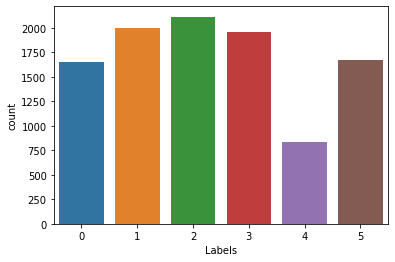

In [10]:
sns.countplot(df['Labels'])

In [11]:
#checking for duplicates
df_no_missing.duplicated().sum()

8

In [12]:
df_no_missing = df_no_missing.drop_duplicates()
df_no_missing.shape

(10230, 3)

In [78]:
df_split = df_no_missing[(df_no_missing.Labels == 5) | (df_no_missing.Labels == 1)]
df_split.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
3,1,Health care reform legislation is likely to ma...,health-care
5,5,The Chicago Bears have had more starting quart...,education
12,1,When Mitt Romney was governor of Massachusetts...,"history,state-budget"
16,5,McCain opposed a requirement that the governme...,federal-budget


Feature Engineering from strings - tf/idf Let's transform the df dataset's Text column into a text vector so we can use it in our prediction tasks

---



In [69]:
# Take the column text
title_text = df_split['Text']

# Create the vectorizer method
tfidf_vec = TfidfVectorizer()

# Transform the text into tf-idf vectors
text_tfidf = tfidf_vec.fit_transform(title_text)

text_tfidf.shape

(3662, 7442)

In [70]:
tfidf_vec.vocabulary_

{'says': 5917,
 'the': 6719,
 'annies': 640,
 'list': 4026,
 'political': 5082,
 'group': 3086,
 'supports': 6547,
 'third': 6749,
 'trimester': 6915,
 'abortions': 364,
 'on': 4696,
 'demand': 1991,
 'health': 3195,
 'care': 1266,
 'reform': 5556,
 'legislation': 3946,
 'is': 3634,
 'likely': 4008,
 'to': 6800,
 'mandate': 4161,
 'free': 2863,
 'sex': 6066,
 'change': 1369,
 'surgeries': 6556,
 'chicago': 1403,
 'bears': 919,
 'have': 3180,
 'had': 3122,
 'more': 4418,
 'starting': 6375,
 'quarterbacks': 5390,
 'in': 3435,
 'last': 3884,
 '10': 8,
 'years': 7416,
 'than': 6709,
 'total': 6829,
 'number': 4613,
 'of': 4657,
 'tenured': 6686,
 'uw': 7081,
 'faculty': 2615,
 'fired': 2743,
 'during': 2271,
 'two': 6963,
 'decades': 1929,
 'when': 7291,
 'mitt': 4383,
 'romney': 5815,
 'was': 7218,
 'governor': 3037,
 'massachusetts': 4210,
 'we': 7243,
 'didnt': 2072,
 'just': 3745,
 'slow': 6213,
 'rate': 5458,
 'growth': 3091,
 'our': 4759,
 'government': 3035,
 'actually': 431,
 'cut'

In [71]:
text_tfidf[3].indices

array([3659, 1858,  431, 3035, 4759, 3091, 5458, 6213, 3745, 2072, 7243,
       4210, 3037, 7218, 5815, 4383, 7291, 4657, 6719], dtype=int32)

Selecting Feature using Text Vectors



































































































































































































































































































































































































































































































































































































































































































In [72]:
def return_weights(vocab, original_vocab, vector, vector_index, top_n):
    zipped = dict(zip(vector[vector_index].indices, vector[vector_index].data))
    
    # Let's transform that zipped dict into a series
    zipped_series = pd.Series({vocab[i]:zipped[i] for i in vector[vector_index].indices})
    
    # Let's sort the series to pull out the top n weighted words
    zipped_index = zipped_series.sort_values(ascending=False)[:top_n].index
    return [original_vocab[i] for i in zipped_index]

In [73]:
#reverse the key value pair in the dict
vocab = {v:k for k,v in tfidf_vec.vocabulary_.items()}
vocab

{5917: 'says',
 6719: 'the',
 640: 'annies',
 4026: 'list',
 5082: 'political',
 3086: 'group',
 6547: 'supports',
 6749: 'third',
 6915: 'trimester',
 364: 'abortions',
 4696: 'on',
 1991: 'demand',
 3195: 'health',
 1266: 'care',
 5556: 'reform',
 3946: 'legislation',
 3634: 'is',
 4008: 'likely',
 6800: 'to',
 4161: 'mandate',
 2863: 'free',
 6066: 'sex',
 1369: 'change',
 6556: 'surgeries',
 1403: 'chicago',
 919: 'bears',
 3180: 'have',
 3122: 'had',
 4418: 'more',
 6375: 'starting',
 5390: 'quarterbacks',
 3435: 'in',
 3884: 'last',
 8: '10',
 7416: 'years',
 6709: 'than',
 6829: 'total',
 4613: 'number',
 4657: 'of',
 6686: 'tenured',
 7081: 'uw',
 2615: 'faculty',
 2743: 'fired',
 2271: 'during',
 6963: 'two',
 1929: 'decades',
 7291: 'when',
 4383: 'mitt',
 5815: 'romney',
 7218: 'was',
 3037: 'governor',
 4210: 'massachusetts',
 7243: 'we',
 2072: 'didnt',
 3745: 'just',
 6213: 'slow',
 5458: 'rate',
 3091: 'growth',
 4759: 'our',
 3035: 'government',
 431: 'actually',
 1858:

In [74]:
# Print out the weighted words
print(return_weights(vocab, tfidf_vec.vocabulary_, text_tfidf, 8, 3))

[2403, 5865, 4910]


In [75]:
def words_to_filter(vocab, original_vocab, vector, top_n):
    filter_list = []
    for i in range(0, vector.shape[0]):
    
        # Here we'll call the function , and extend the list we're creating
        filtered = return_weights(vocab, original_vocab, vector, i, top_n)
        filter_list.extend(filtered)
    # Return the list in a set, so we don't get duplicate word indices
    return set(filter_list)

# Call the function to get the list of word indices
filtered_words = words_to_filter(vocab, tfidf_vec.vocabulary_, text_tfidf, 3)
print(filtered_words)

{0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 26, 28, 29, 30, 32, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 90, 91, 94, 95, 97, 98, 99, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 235, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 250, 251, 252,

In [76]:
# By converting filtered_words back to a list, we can use it to filter the columns in the text vector
filtered_text = text_tfidf[:, list(filtered_words)]
print(filtered_text)

  (0, 1736)	0.32962865285959914
  (0, 4085)	0.1380371157612332
  (0, 314)	0.2944867151084029
  (0, 6055)	0.3812970422355391
  (0, 5910)	0.2797352135561342
  (0, 5729)	0.29702952868320326
  (0, 4433)	0.2875918665193756
  (0, 3511)	0.3486979180591432
  (0, 552)	0.4003663074350831
  (0, 5883)	0.07064595227058747
  (1, 5738)	0.4124639460857492
  (1, 1195)	0.30459588517350983
  (1, 5305)	0.33409405636598233
  (1, 2507)	0.32730066858781376
  (1, 3622)	0.3463631365960118
  (1, 5954)	0.10701717269760518
  (1, 3494)	0.3463631365960118
  (1, 3169)	0.14149150509359296
  (1, 3441)	0.28747791512145626
  (1, 4864)	0.28604472635944
  (1, 1109)	0.20797856790947114
  (1, 2795)	0.19804718083385434
  (2, 1680)	0.2391402987735071
  (2, 6094)	0.16187467714900788
  (2, 1982)	0.17633004294563862
  :	:
  (3660, 5101)	0.34246124104513204
  (3660, 5519)	0.2411192874896048
  (3660, 6300)	0.2652150040362227
  (3660, 2647)	0.28634839323525824
  (3660, 1930)	0.24353879940287335
  (3660, 5944)	0.2184603360456756
  (

In [77]:
# Split the dataset according to the class distribution of category_desc, using the filtered_text vector
train_X, test_X, train_y, test_y = train_test_split(filtered_text.toarray(), df_split['Labels'], stratify=df_split['Labels'])

#create your model
nb = GaussianNB()

# Fit the model to the training data
nb.fit(train_X,train_y)

#predict 
y_pred = nb.predict(test_X)
print(accuracy_score(test_y,y_pred))

0.5131004366812227
